In [63]:
# from astroquery.gaia import Gaia
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import NearestNeighbors
import scipy as sp
from scipy.spatial import distance
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, StandardScaler
import scienceplots
import networkx as nx
# import mplcursors


import warnings
warnings.filterwarnings('ignore')

## Functions

In [64]:
def min_span_tree(df_data, params, num_std = 1, manual_th=True, threshold=.85, y_limit=5, fig=True):

    np.random.seed(101)

    df_data = df_data.reset_index().drop('index', axis=1)
    data = df_data.copy()
    scaler = StandardScaler()
    data[params] = scaler.fit_transform(data[params])

    nn = NearestNeighbors(n_neighbors=3, metric='minkowski')
    nn.fit(data[params])
    distances, indices = nn.kneighbors(data[params])

    # Create an empty graph
    G = nx.Graph()

    # Add edges with distances to the graph
    n_samples = data.shape[0]
    for i in range(n_samples):
        for j in range(1, len(indices[i])):
            neighbor_index = indices[i, j]
            weight = distances[i, j]
            G.add_edge(i, neighbor_index, weight=weight)

    # Compute the minimum spanning tree
    mst = nx.minimum_spanning_tree(G)

    # Weight of the MST
    edge_weights = [X['weight'] for _, _, X in mst.edges(data=True)]

    if not manual_th: # use threshold to filter
        threshold = np.mean(edge_weights) + num_std * np.std(edge_weights)
        print('threshold:', round(threshold, 2))

    if fig:
        # Sort the edge weights in ascending order
        sorted_weights = sorted(edge_weights)

        # Plot sorted edge weights
        plt.figure(figsize=(4,2))
        plt.plot(sorted_weights)
        plt.hlines(threshold, 0,len(df_data), colors='red')
        plt.ylim(0, y_limit)
        plt.xlabel('Edge Index')
        plt.ylabel('Edge Weight')
        plt.title('Sorted Edge Weights')
        plt.show()

    # Identify the nodes with weights greater than the mean weight
    nodes_to_remove = [node for node in mst.nodes() if mst.degree(node, weight='weight') > threshold]

    # Remove the identified nodes from the MST
    mst.remove_nodes_from(nodes_to_remove)

    df_data['MST_cluster'] = 1
    df_data.loc[nodes_to_remove, 'MST_cluster'] = 0

    return df_data


def preprocess_cluster(data, g_mean_th=19):
    """
    ------
    parallax > 0

    phot_g_mean_mag < g_mean_th
    ------
    """
    data = data[data['parallax'] > 0]
    data = data[data['phot_g_mean_mag'] < g_mean_th]
    data['Gmg'] = data['phot_g_mean_mag'] + (5 * np.log10(data['parallax']) - 10)
    data['L'] = 10**(0.4*(4.83 - data['Gmg']))
    data = data[(abs(data['pmra']) < 10) & (abs(data['pmdec']) < 10)]
    print(len(data))
    return data


def cmd_plot(data, x_axis, y_axis, alpha=0.8, s=5):
    """
    -------
    plot isochrone
    -------
    """

    fig = plt.figure(figsize=(6,4), dpi=100)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, color='black')
    plt.gca().invert_yaxis();


def joint_plot(data):

    plt.figure(dpi=90)
    sns.jointplot(
        data=data,
        x="pmra", y="pmdec",
        kind="kde"
        )
    plt.show()


def fit_curve(data, column, bins = 100):

    plt.figure(figsize=(8,2), dpi=80)
    counts, bins, patches = plt.hist(data[column], bins = bins)

    # Define the Gaussian function
    def gaussian(x, amp, mu, sigma):
        return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

    # data
    x_data = bins[:-1]
    y_data = counts

    # Fit the Gaussian function to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data, maxfev=5000)

    plt.figure(figsize=(8,2), dpi=80)
    # Plot the original data and the fitted curve
    sns.scatterplot(x=x_data, y=y_data, label=column)
    plt.plot(x_data, gaussian(x_data, *popt), color='red', label='Fit')
    plt.legend()
    plt.show()

    return popt


def guassian_filter(data, column, mu, std):
    up = round(mu + 3 * std, 2)
    low = round(mu - 3 * std, 2)

    if up > low:
        print(f'{column} upper bound:', up)
        print(f'{column} lower bound:', low)
        df = data[(data[column] < up) & (data[column] > low)]
    else:
        print(f'{column} upper bound:', low)
        print(f'{column} lower bound:', up)
        df = data[(data[column]< low) & (data[column] > up)]

    print('cluster length:', len(df))
    return df


def luminosity_density(cluster_3d, clusterdf):
    """
    --------
    cluster_3d --> measuring distance in that dataframe

    clusterdf --> main dataframe
    -------
    """
    # create a NearestNeighbors object and fit the dataset
    nbrs = NearestNeighbors(n_neighbors=6, metric='minkowski').fit(cluster_3d)

    # find the 5 nearest neighbors for each data point including itself
    distances, indices = nbrs.kneighbors(cluster_3d)

    # find maximum distance among 5 neighbors
    max_distances = np.amax(distances, axis=1)

    # sphere of that max distance
    spheres = (4/3) * np.pi * (max_distances ** 3)

    # sum of luminosities of each 6 nn
    lum_sum = []
    for i in range(len(clusterdf)):
        lum_sum.append(np.sum(clusterdf.iloc[indices[i]]['L']))

    # luminosity density
    lum_dens = lum_sum / spheres

    return lum_dens



def lum_plot(data):
    """
    --------
    plot for luminosity density profile
    --------
    """

    plt.figure(figsize=(12,6), dpi=200)
    plt.plot(range(len(data)), np.sort(data))
    plt.ylabel('ΔL/ΔV')
    plt.title('luminosity density profile');


def cmd_plotly(data, x_axis, y_axis, huex = 'cluster', ax=None, alpha=0.8, s=7, theme=None):
    """
    -------
    plot isochrone
    -------
    """
    with plt.style.context(['ieee']):
        if ax is None:
            fig = plt.figure(figsize=(5,4), dpi=100)
            ax = fig.add_subplot(111)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, hue = huex, ax=ax, palette=theme)
        ax.invert_yaxis()

In [65]:
df_coin_gaia_12  = pd.read_parquet('./COIN-Gaia_12_(180a)-result/COIN-Gaia_12_(180a)-result.parquet')

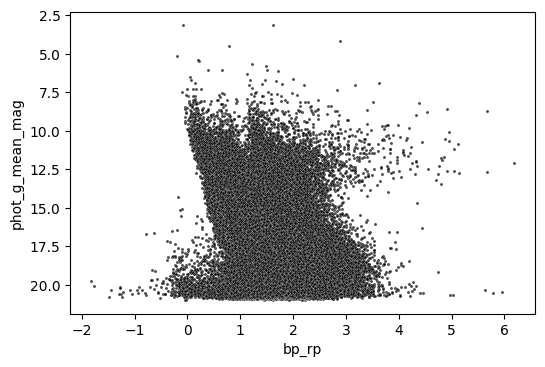

In [66]:
cmd_plot(data=df_coin_gaia_12, x_axis='bp_rp', y_axis='phot_g_mean_mag', s=5, alpha=.7)

In [67]:
df_coin_gaia_12.columns

Index(['SOURCE_ID', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'ruwe', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'bp_rp', 'bp_g', 'g_rp', 'radial_velocity', 'phot_variable_flag', 'l',
       'b', 'non_single_star', 'has_xp_continuous', 'has_xp_sampled',
       'has_rvs', 'has_epoch_photometry', 'has_epoch_rv', 'has_mcmc_gspphot',
       'has_mcmc_msc', 'teff_gspphot', 'logg_gspphot', 'mh_gspphot',
       'distance_gspphot', 'azero_gspphot', 'ag_gspphot', 'ebpminrp_gspphot'],
      dtype='object')

In [68]:
len(df_coin_gaia_12)

1062736

----

# MST Method

## 1. Initial Filters on Data

In [306]:
df_coin_gaia_12_init = df_coin_gaia_12.drop(['ra_error', 'dec_error', 
       'pm', 'pmra_error', 'pmdec_error',
       'ruwe', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'radial_velocity', 'phot_variable_flag', 'l',
       'b', 'non_single_star', 'has_xp_continuous', 'has_xp_sampled',
       'has_rvs', 'has_epoch_photometry', 'has_epoch_rv', 'has_mcmc_gspphot',
       'has_mcmc_msc', 'teff_gspphot', 'logg_gspphot', 'mh_gspphot',
       'distance_gspphot', 'azero_gspphot', 'ag_gspphot', 'ebpminrp_gspphot'], axis=1).dropna(axis=0)

df_coin_gaia_12_init = df_coin_gaia_12_init[df_coin_gaia_12_init['parallax_error'] < 0.2]

In [307]:
len(df_coin_gaia_12_init)

500872

In [308]:
# Initial Filter on PMRA and PMDEC 

def filter_proper_motion(data, pmra, pmdec, d_pmra=2, d_pmdec=2):
    # d_pmra = 3 * d_pmra
    # d_pmdec = 3 * d_pmdec
    return data[(abs(data['pmra'] - pmra) < d_pmra) & (abs(data['pmdec'] - pmdec) < d_pmdec)]

def filter_parallax(data, parallax, delta = .2):
    return data[(abs(data['parallax'] - parallax) < delta)]

# def filter_distance(data, r_med, delta = 100):
#     return data[(abs(data['r_med_geo'] - r_med) < delta)] # r_med_geo

In [321]:
df_coin_gaia_12_init = filter_proper_motion(df_coin_gaia_12_init, 2.55, -4.71, 0.3, 0.3)
df_coin_gaia_12_init = filter_parallax(df_coin_gaia_12_init, 1.0, 0.2)

In [322]:
len(df_coin_gaia_12_init)

291

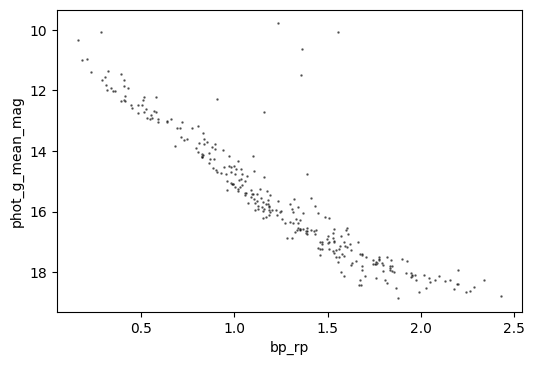

In [323]:
cmd_plot(data = df_coin_gaia_12_init, x_axis = 'bp_rp', y_axis = 'phot_g_mean_mag', s = 3, alpha = .7)

-------

In [324]:
# ### Gaussian Filters

# def namestr(obj, namespace):
#     return [name for name in namespace if namespace[name] is obj] # print name of variable

# def guassian_fit_filter(data, parameter, num_bins=80):
#     print('\n',namestr(data, globals())[0])
#     amp, mu, std = fit_curve(data, parameter, bins=num_bins)
#     return guassian_filter(data, parameter, mu, std)

In [325]:
# sns.set_style('ticks')

In [326]:
# cmd_plot(df_coin_gaia_12_init, 'bp_rp', 'phot_g_mean_mag', alpha=0.5)

-------

### 2. MST

In [327]:
params = ['ra', 'dec', 'parallax'] #,'pmra','pmdec'

In [328]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_coin_gaia_12_init[params])

df_scaled = pd.DataFrame(data=x_scaled, columns=params)
df_scaled['SOURCE_ID'] = df_coin_gaia_12_init['SOURCE_ID'].values

threshold: 1.03


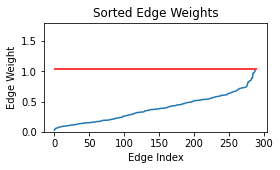

In [329]:
df_scaled = min_span_tree(df_scaled, params=params, num_std=3, manual_th=False, threshold=.2, y_limit=1.8, fig=True)

In [330]:
print(len(df_scaled[df_scaled['MST_cluster']==1]))
print(len(df_scaled[df_scaled['MST_cluster']==0]))

210
81


In [331]:
df_coin_gaia_12_mst = df_coin_gaia_12_init.merge(df_scaled[["MST_cluster", "SOURCE_ID"]], on='SOURCE_ID', how='left')

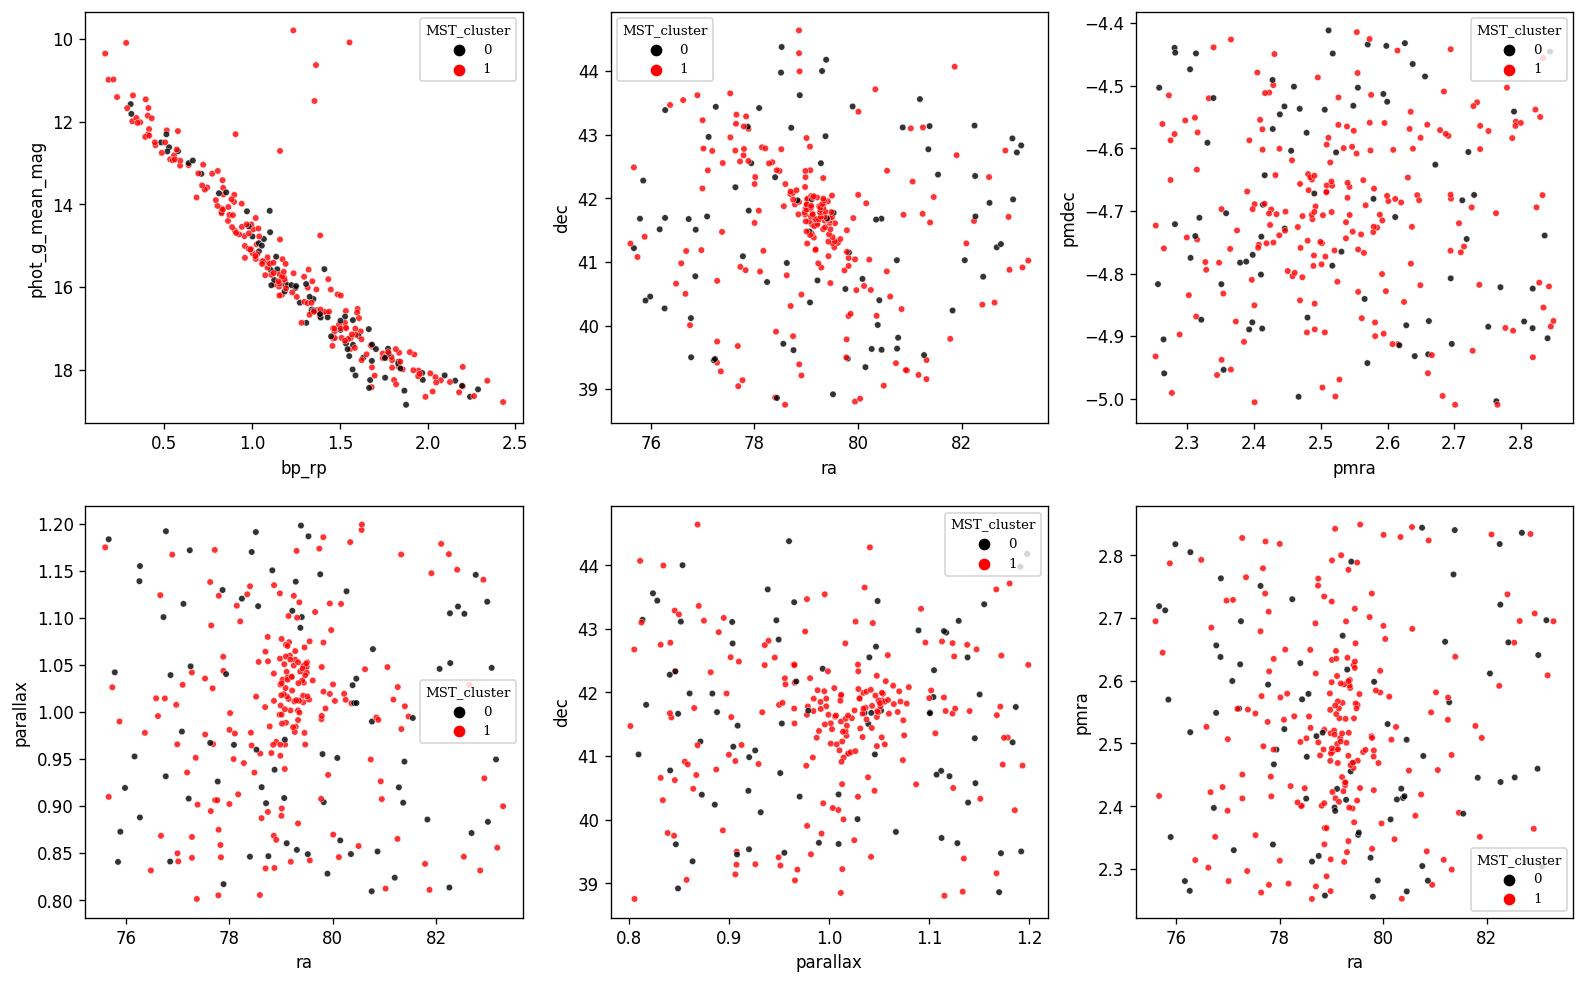

In [332]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=120)

cmd_plotly(df_coin_gaia_12_mst, 'bp_rp', 'phot_g_mean_mag', huex='MST_cluster', s=15, alpha=.8,ax=axes[0,0], theme={1:'red', 0:'black'})
cmd_plotly(df_coin_gaia_12_mst, 'ra', 'dec', huex='MST_cluster', s=15, alpha=.8, ax=axes[0,1], theme={1:'red', 0:'black'})
axes[0,1].invert_yaxis()

cmd_plotly(df_coin_gaia_12_mst, 'pmra', 'pmdec', huex='MST_cluster', s=15, alpha=.8, ax=axes[0,2], theme={1:'red', 0:'black'})
axes[0,2].invert_yaxis()
cmd_plotly(df_coin_gaia_12_mst, 'ra', 'pmra', huex='MST_cluster', s=15, alpha=.8, ax=axes[1,2], theme={1:'red', 0:'black'})
axes[1,2].invert_yaxis()

cmd_plotly(df_coin_gaia_12_mst, 'ra', 'parallax', huex='MST_cluster', s=15, alpha=.8, ax=axes[1,0], theme={1:'red', 0:'black'})
axes[1,0].invert_yaxis()
cmd_plotly(df_coin_gaia_12_mst, 'parallax', 'dec', huex='MST_cluster', s=15, alpha=.8, ax=axes[1,1], theme={1:'red', 0:'black'})
axes[1,1].invert_yaxis()

#### Statistical Approach (Finding Outliers)

In [333]:
df_coin_gaia_12_mst = df_coin_gaia_12_mst[df_coin_gaia_12_mst['MST_cluster']==1]
df_coin_gaia_12_mst = df_coin_gaia_12_mst.reset_index()

In [334]:
scaler = StandardScaler()
temp_df = pd.DataFrame()
to_drop = []

temp_df[['parallax', 'ra', 'dec', 'pmra', 'pmdec']] = scaler.fit_transform(
    df_coin_gaia_12_mst[['parallax', 'ra', 'dec', 'pmra', 'pmdec']]
)

for i in ['parallax', 'ra', 'dec', 'pmra', 'pmdec']:
    outliers = temp_df[abs(temp_df[i]) > 3].index
    to_drop.extend(outliers)

df_coin_gaia_12_mst = df_coin_gaia_12_mst.drop(to_drop)

In [335]:
len(df_coin_gaia_12_mst)

210

### 3. GMM

In [336]:
def gassian_mixture(data, parameters = ['pmra', 'pmdec', 'parallax', 'ra', 'dec']):
    
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[parameters])
    
    gm = GaussianMixture(n_components=2, random_state=0)

    y_pred = gm.fit_predict(x_scaled)
    y_prob = gm.predict_proba(x_scaled)

    data['gmm_pred'] = y_pred
    data['gmm_prob'] = np.amax(y_prob,axis=1)
    return data, gm

In [337]:
df_coin_gaia_12_cluster, model = gassian_mixture(df_coin_gaia_12_mst)

In [338]:
df_coin_gaia_12_cluster.gmm_pred.value_counts()

0    111
1     99
Name: gmm_pred, dtype: int64

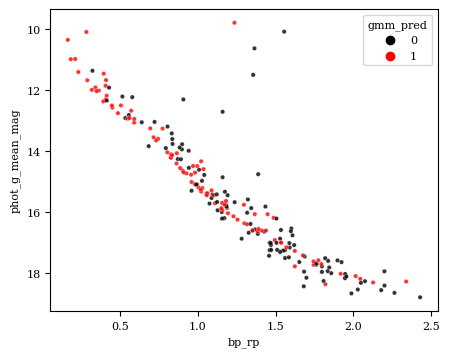

In [339]:
cmd_plotly(df_coin_gaia_12_cluster, 
           'bp_rp', 'phot_g_mean_mag', huex='gmm_pred', s=10, alpha=0.8)

(-1.0, 5.0)

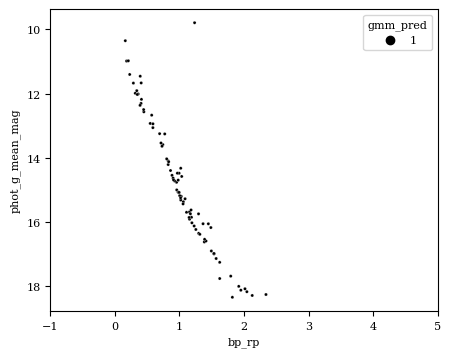

In [340]:
cmd_plotly(df_coin_gaia_12_cluster[(df_coin_gaia_12_cluster['gmm_pred']==1) & (df_coin_gaia_12_cluster['gmm_prob']>=0.8)], 
           'bp_rp', 'phot_g_mean_mag', huex='gmm_pred', s=5, alpha=1)
plt.xlim(-1,5)

In [341]:
### cluster stars

len(df_coin_gaia_12_cluster[(df_coin_gaia_12_cluster['gmm_pred']==1)])

99

In [342]:
### high probable stars
len(df_coin_gaia_12_cluster[(df_coin_gaia_12_cluster['gmm_pred']==1) & (df_coin_gaia_12_cluster['gmm_prob']>=0.9)])

75

## Evaluation

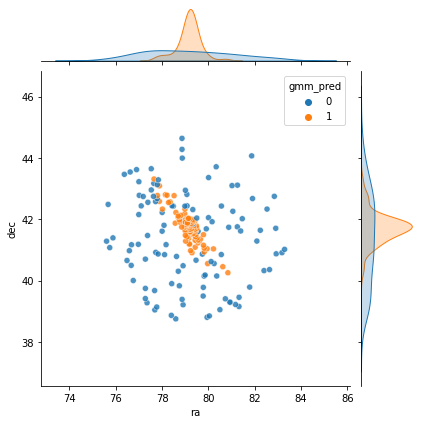

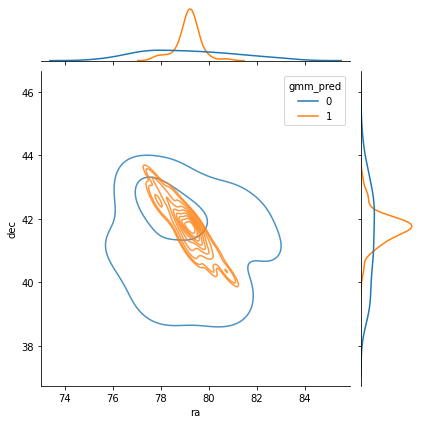

In [343]:
sns.jointplot(data=df_coin_gaia_12_cluster, x='ra', y='dec', kind='scatter', hue='gmm_pred', alpha=.8)
sns.jointplot(data=df_coin_gaia_12_cluster, x='ra', y='dec', kind='kde', hue='gmm_pred', alpha=.8);

In [344]:
def black_body_plot(data, x_axis, y_axis, ax=None, alpha=0.8, s=8):
    
    with plt.style.context(['ieee']):
        if ax is None:
#             fig = plt.figure(figsize=(4,4), dpi=100)
            ax = fig.add_subplot(111)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, ax=ax, color='black')
        ax.invert_xaxis()

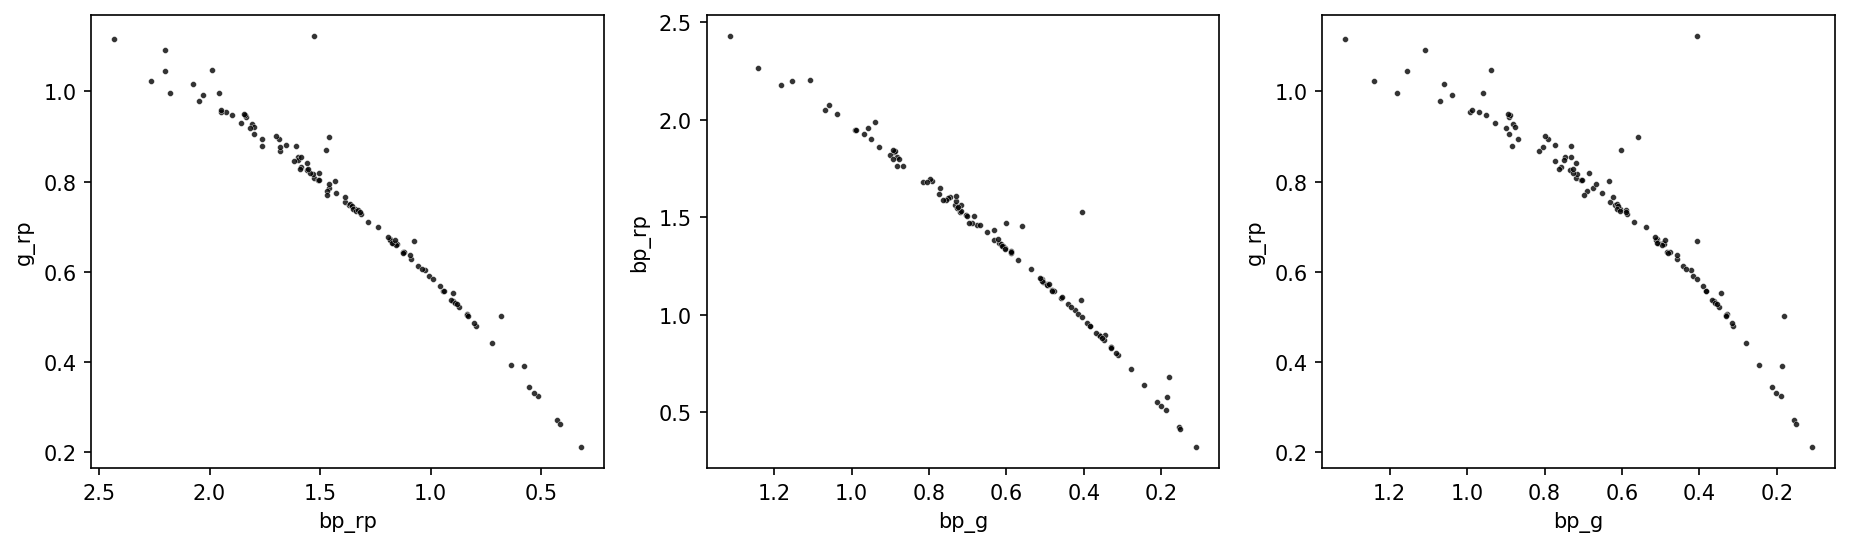

In [345]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=150)
black_body_plot(df_coin_gaia_12_cluster[(df_coin_gaia_12_cluster['gmm_pred']==0)], 'bp_rp', 'g_rp', ax=axes[0])
# black_body_plot(stars, 'bp_rp', 'g_rp', ax=axes[0], s=50)

black_body_plot(df_coin_gaia_12_cluster[(df_coin_gaia_12_cluster['gmm_pred']==0)], 'bp_g', 'bp_rp', ax=axes[1])
# black_body_plot(stars, 'bp_rp', 'g_rp', ax=axes[1], s=50)

black_body_plot(df_coin_gaia_12_cluster[(df_coin_gaia_12_cluster['gmm_pred']==0)], 'bp_g', 'g_rp', ax=axes[2])
# black_body_plot(stars, 'bp_rp', 'g_rp', ax=axes[2], s=50)

#### King Profile

In [346]:
cluster = df_coin_gaia_12_cluster[(df_coin_gaia_12_cluster['gmm_pred']==1)]

In [347]:
galactic_coord = SkyCoord(l=np.mean(cluster['ra']) * u.deg, b=np.mean(cluster['dec']) * u.deg, frame='galactic')

icrs_coord = galactic_coord.transform_to('icrs')

print("RA (ICRS J2000):", icrs_coord.ra.to_string(u.hour))
print("Dec (ICRS J2000):", icrs_coord.dec.to_string(u.degree))

RA (ICRS J2000): 16h35m52.90358883s
Dec (ICRS J2000): 51d32m29.1709815s


In [348]:
np.mean(cluster['ra']), np.mean(cluster['dec'])

(79.15309204567323, 41.73611395655775)

In [349]:
def king_profile_function(x, f_b, f_0, R_c):
    return (f_b + (f_0 / (1 + (x/R_c)**2)))

def fit_king_profile(data, plotting = True, norm_density=False, radius_num = 13):
    """
    returns coefs: [f_b, f_0, R_c], R_t
    """

    center = (np.mean(data['ra']), np.mean(data['dec']))  #  center of cluster     
    max_r = round(max(np.linalg.norm(center - data[['ra', 'dec']], axis=1)), 2) + 0.01 

    radii = np.linspace(0, max_r, radius_num)  # Define the radii of the concentric circles
    x = np.linspace(0, max_r, num=100)

    # star density
    star_densities = []
    for i in range(radius_num - 1):
        r_inner = radii[i]
        r_outer = radii[i + 1]

        # Calculate the distances between the center and each star's position
        distances = np.sqrt(
            (data['ra'] - center[0])**2 + (data['dec'] - center[1])**2
        )

        # Count the number of stars within the current circle
        stars_within_circle = data[(distances >= r_inner) & (distances < r_outer)]
        star_count = len(stars_within_circle)

        # Calculate the area of the circle
        circle_area = np.pi * (r_outer**2 - r_inner**2)

        # Calculate the star density within the circle
        star_density = star_count / circle_area
        star_densities.append(star_density)

    star_densities = np.array(star_densities)

    # normal density
    normal_densities = star_densities / np.linalg.norm(star_densities)

    if norm_density:
        star_densities = normal_densities

    # fitting data on king profile
    coefs, cov = curve_fit(king_profile_function, radii[:-1], star_densities, maxfev=5000, bounds=[0, np.inf])

    R_tidal = coefs[2]*np.sqrt(coefs[1]/(3*np.sqrt(cov[0,0]))-1)

    if plotting:
        with plt.style.context(['science','ieee', 'no-latex']):
            # Plotting the density profile
            plt.figure(figsize=(5, 3), dpi=150)
            plt.plot(radii[:-1], star_densities, 'o', ms=2, color='black')
            plt.plot(x, king_profile_function(x, coefs[0], coefs[1], coefs[2]), '--', color='red', lw=1.7)
            plt.xlabel('Radius from Center (arcmin)')
            plt.ylabel('Star Density (stars/pc\u00b2)')
#             plt.savefig('king_profile.jpg')
            plt.show()

    return coefs, R_tidal, cov

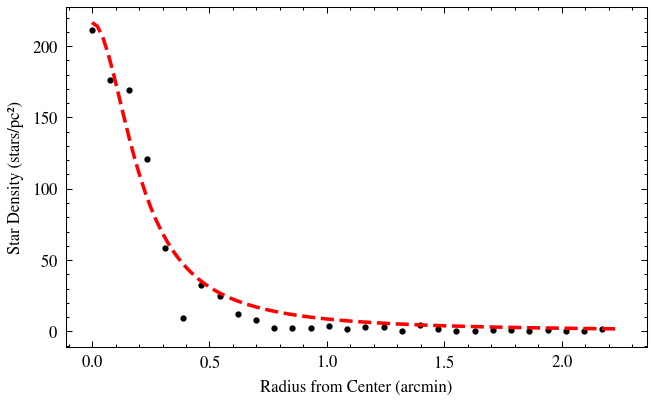

Coin Gaia 12
f_b: 0.0 std: 3.12
f_0: 216.52
R_c: 0.2
R_t: 0.96


In [350]:
coefs, R_t, cov = fit_king_profile(cluster, norm_density=False, radius_num= 30)

print('Coin Gaia 12')
print("f_b:", round(coefs[0], 2), 'std:', round(np.sqrt(cov[0][0]), 2))
print("f_0:", round(coefs[1], 2))
print("R_c:", round(coefs[2], 2))
print('R_t:', round(R_t, 2))

In [351]:
print('Err Rc:',np.sqrt(cov[2, 2]))
print('Err Rt:',(coefs[2] + np.sqrt(cov[2, 2]))*np.sqrt(coefs[1]/(3*np.sqrt(cov[0,0]))-1))

Err Rc: 0.017379253540163044
Err Rt: 1.0460781464327507


In [352]:
center = (np.mean(cluster['ra']), np.mean(cluster['dec']))
distances = np.sqrt((cluster['ra'] - center[0])**2 + (cluster['dec'] - center[1])**2)
stars_within_core = cluster[(distances < coefs[2])]
stars_out_of_bound = cluster[(distances > R_t)]

In [353]:
len(stars_within_core)

26

In [354]:
len(stars_out_of_bound)

16

In [355]:
# df_coin_gaia_12_cluster = df_coin_gaia_12_cluster.merge(
#     df_coin_gaia_12[["source_id", "r_med_geo"]], on='source_id', how='left').drop("index", axis=1)

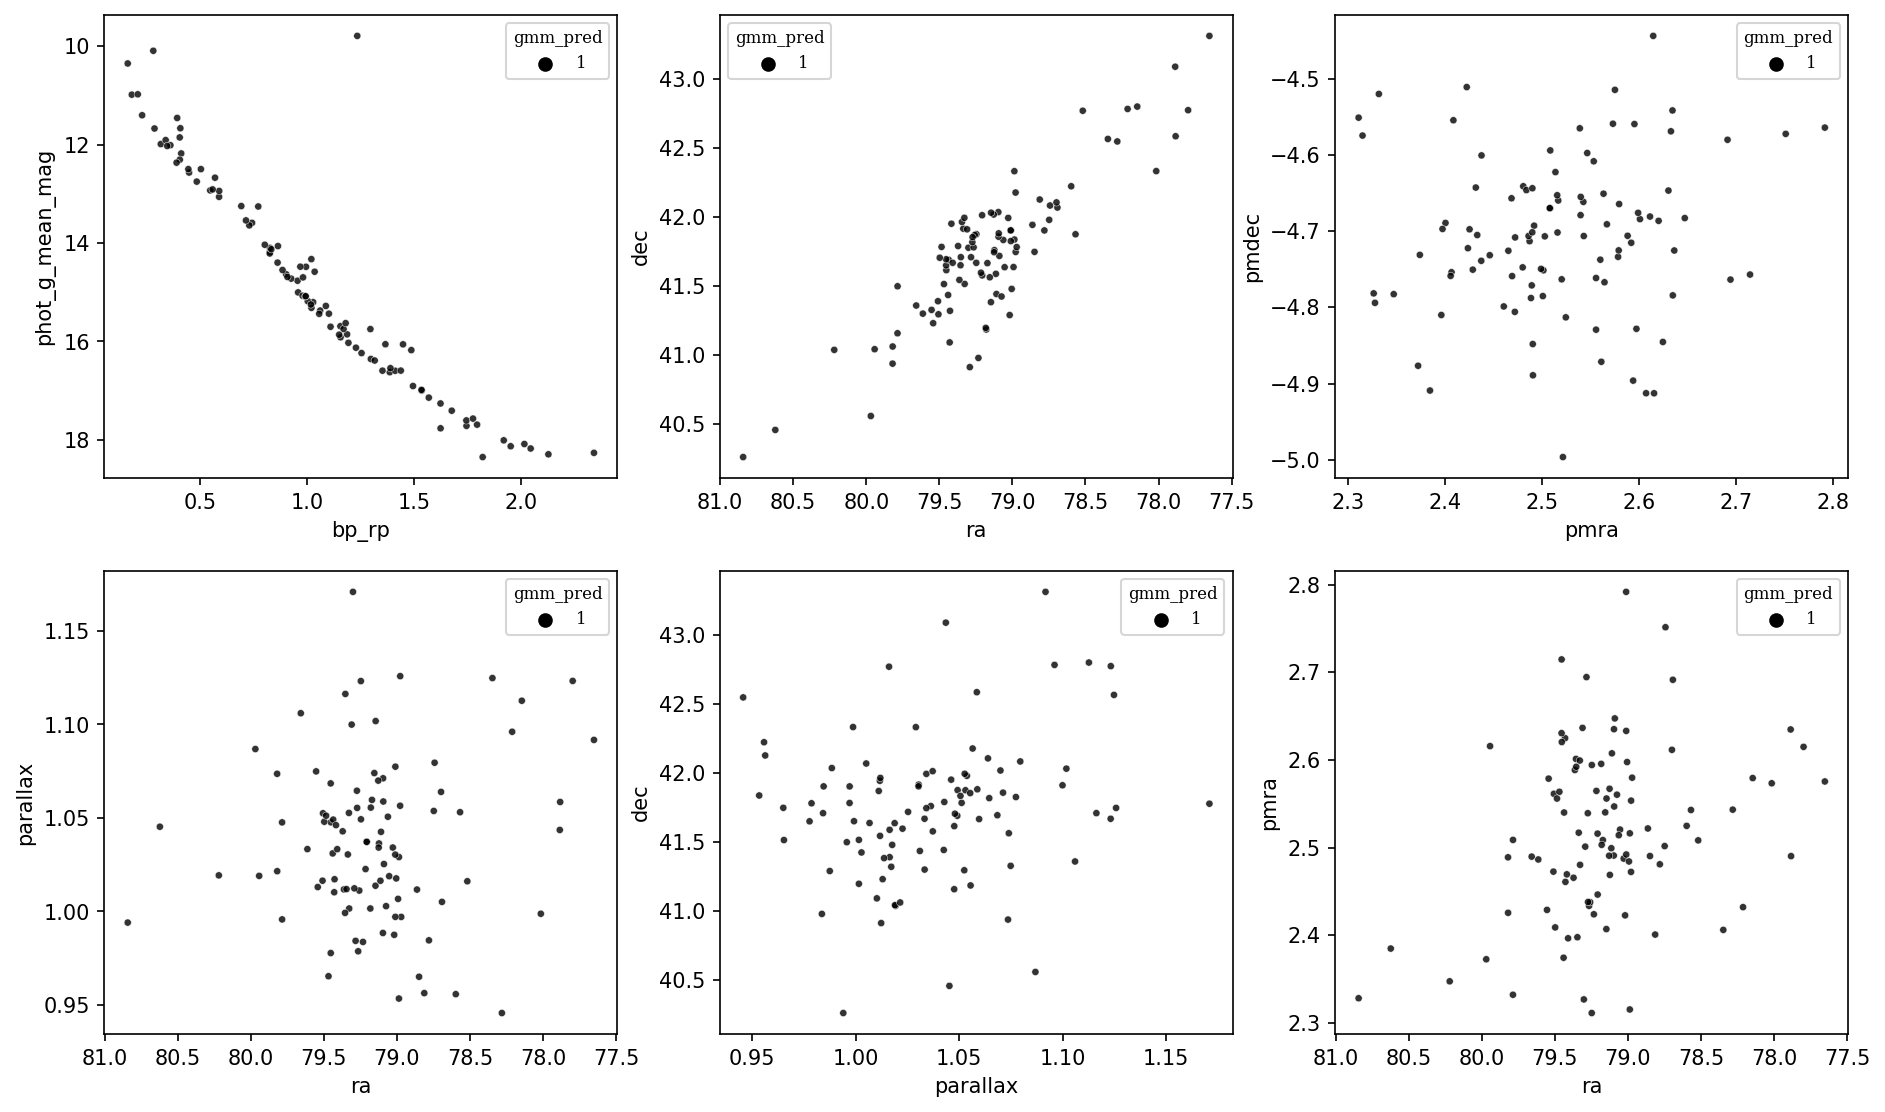

In [356]:
### PLOT THE CLUSTERS

fig, axes = plt.subplots(2, 3, figsize=(15, 9), dpi=150)

cmd_plotly(cluster, 'bp_rp', 'phot_g_mean_mag', huex='gmm_pred', s=12, alpha=.8, ax=axes[0,0])
cmd_plotly(cluster, 'ra', 'dec', huex='gmm_pred', s=12, alpha=.8, ax=axes[0,1])
axes[0,1].invert_yaxis()
axes[0,1].invert_xaxis()
cmd_plotly(cluster, 'ra', 'parallax', huex='gmm_pred', s=12, alpha=.8, ax=axes[1,0])
axes[1,0].invert_yaxis()
axes[1,0].invert_xaxis()
cmd_plotly(cluster, 'parallax', 'dec', huex='gmm_pred', s=12, alpha=.8, ax=axes[1,1])
axes[1,1].invert_yaxis()
cmd_plotly(cluster, 'pmra', 'pmdec', huex='gmm_pred', s=12, alpha=.8, ax=axes[0,2])
axes[0,2].invert_yaxis()
cmd_plotly(cluster, 'ra', 'pmra', huex='gmm_pred', s=12, alpha=.8, ax=axes[1,2])
axes[1,2].invert_xaxis()
axes[1,2].invert_yaxis()

In [357]:
len(cluster[cluster["gmm_prob"]>=0.9])

75

In [358]:
len(cluster[cluster["gmm_prob"]>=0.8])

85

In [359]:
len(cluster[cluster["gmm_prob"]>=0.6])

97

In [360]:
len(cluster)

99

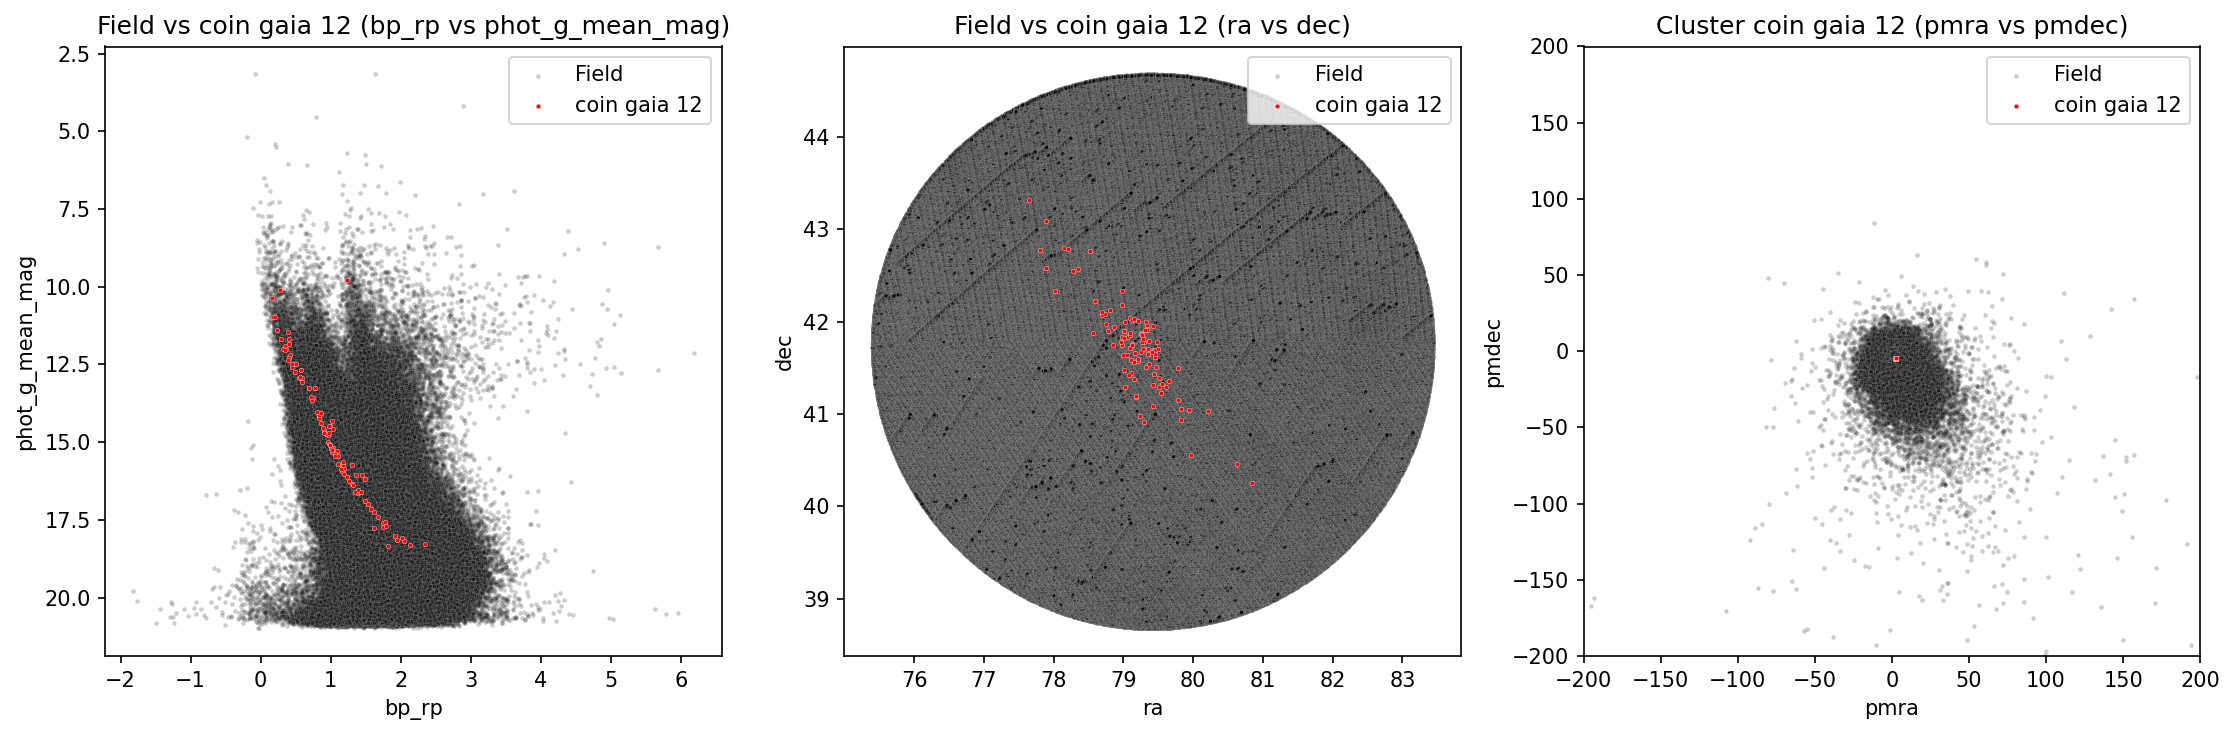

In [183]:
# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

# First subplot: bp_rp vs phot_g_mean_mag
sns.scatterplot(data=df_coin_gaia_12, x='bp_rp', y='phot_g_mean_mag', s=5, alpha=.2, color="black", label="Field", ax=axes[0])
sns.scatterplot(data=cluster,
                x='bp_rp', y='phot_g_mean_mag', s=5, alpha=1, color='red', label="coin gaia 12", ax=axes[0])
axes[0].invert_yaxis()
axes[0].legend()
axes[0].set_title("Field vs coin gaia 12 (bp_rp vs phot_g_mean_mag)")

# Second subplot: ra vs dec
sns.scatterplot(data=df_coin_gaia_12, x='ra', y='dec', s=5, alpha=.2, color="black", label="Field", ax=axes[1])
sns.scatterplot(data=cluster,
                x='ra', y='dec', s=5, alpha=1, color='red', label="coin gaia 12", ax=axes[1])
axes[1].legend()
axes[1].set_title("Field vs coin gaia 12 (ra vs dec)")

# Third subplot: pmra vs pmdec
sns.scatterplot(data=df_coin_gaia_12, 
                x='pmra', y='pmdec', s=5, alpha=.2, color="black", label="Field", ax=axes[2])
sns.scatterplot(data=cluster,
                x='pmra', y='pmdec', s=5, alpha=1, color='red', label="coin gaia 12", ax=axes[2])
axes[2].set_xlim(-200, 200)
axes[2].set_ylim(-200, 200)
axes[2].legend()
axes[2].set_title("Cluster coin gaia 12 (pmra vs pmdec)")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("coin_gaia_12.png")
plt.show()

----

### Additional Notes on Coin Gaia 12

with `pmra delta = 0.1` & `pmdec delta = 0.2` the final results would be as follows:

- Not Good King profile 
- `80` Cluster members
- CMD very neat!

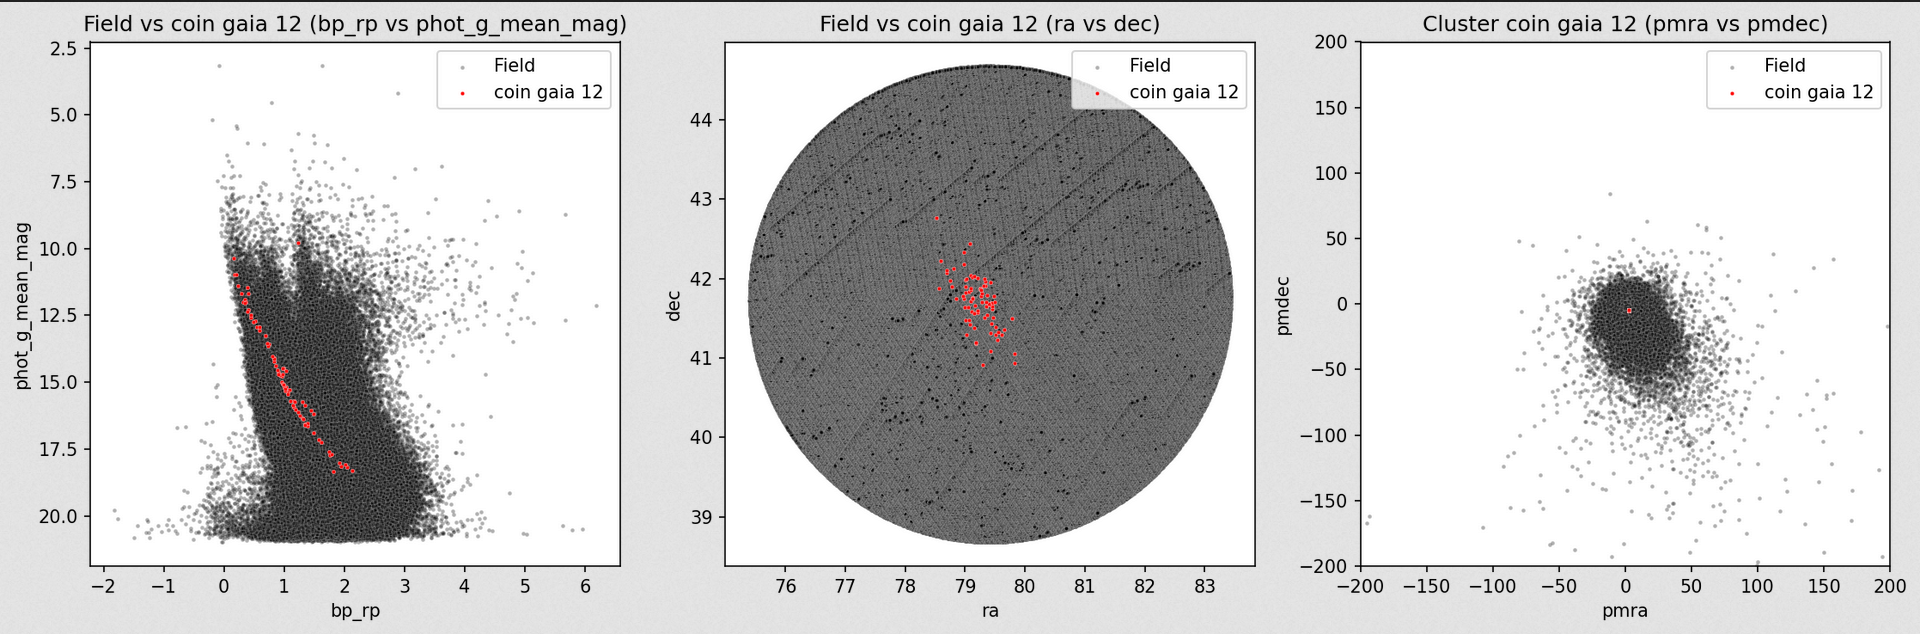